# Baseline Models External Dataset Evaluation: Testing Generalization

## Introduction and Evaluation Philosophy

This notebook evaluates our trained baseline models (Logistic Regression and Random Forest) on external datasets to assess their real-world generalization capabilities. While these models achieved excellent performance on the WELFake test set (>96% accuracy), the critical question for deployment is: **How well do they perform on completely new data sources?**

### Why External Validation Matters

External validation tests whether our models learned generalizable patterns of fake news detection or simply memorized specific characteristics of the WELFake dataset. This evaluation uses:

- **Manually verified real news articles** from reputable sources
- **AI-generated fake news articles** representing modern misinformation techniques

The combination tests robustness across different writing styles, topics, and misinformation strategies that weren't present in the original training data.

## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

## Loading Pre-Trained Models and Components

We'll load the optimized models and preprocessing components from our training phase to ensure consistency.

### Loading the TF-IDF Vectorizer

In [2]:
# Load the fitted TF-IDF vectorizer from training
with open('../../ml_models/baseline/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
print(f"TF-IDF vectorizer loaded")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,} features")
print(f"Max features used: {tfidf_vectorizer.max_features}")

TF-IDF vectorizer loaded
Vocabulary size: 10,000 features
Max features used: 10000


### Loading the Trained Models

In [3]:
# Load the optimized Logistic Regression model
with open('../../ml_models/baseline/lr_model.pkl', 'rb') as f:
    lr_model = pickle.load(f)
    
print("Logistic Regression model loaded")
print(f"Regularization strength (C): {lr_model.C}")
print(f"Max iterations: {lr_model.max_iter}")

# Load the optimized Random Forest model  
with open('../../ml_models/baseline/rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)
    
print("Random Forest model loaded")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Max depth: {rf_model.max_depth}")
print(f"Min samples per split: {rf_model.min_samples_split}")

Logistic Regression model loaded
Regularization strength (C): 10.0
Max iterations: 3000
Random Forest model loaded
Number of trees: 200
Max depth: None
Min samples per split: 5


## External Dataset Preparation

### Loading External Datasets

In [4]:
# Load external validation datasets
real_df = pd.read_csv('../datasets/manual_real.csv')
fake_df = pd.read_csv('../datasets/fake_claude.csv')

print(f"External real news articles: {len(real_df)}")
print(f"External fake news articles: {len(fake_df)}")
print(f"Total external validation samples: {len(real_df) + len(fake_df)}")

External real news articles: 429
External fake news articles: 429
Total external validation samples: 858


### Preparing External Data for Evaluation

In [5]:
# Prepare real news data (label = 0 for real news)
real_df['label'] = 0
real_articles = real_df[['text', 'label']].copy()
real_articles.columns = ['combined_text', 'label']

# Prepare fake news data (label = 1 for fake news)  
fake_df['label'] = 1
fake_articles = fake_df[['text', 'label']].copy()
fake_articles.columns = ['combined_text', 'label']

# Combine into single external validation dataset
external_df = pd.concat([real_articles, fake_articles], ignore_index=True)

# Extract features and labels for model evaluation
X_external = external_df['combined_text']
y_external = external_df['label']

print(f"Combined external dataset: {len(external_df)} articles")
print(f"Class balance: {y_external.mean():.1%} fake news")

Combined external dataset: 858 articles
Class balance: 50.0% fake news


### Transforming Text to Model Features

In [6]:
# Transform external text data using the fitted TF-IDF vectorizer
# Important: Use transform (not fit_transform) to maintain consistency
print("Transforming external text data to TF-IDF features...")
start_time = time.time()

X_external_tfidf = tfidf_vectorizer.transform(X_external)

transform_time = time.time() - start_time
print(f"Transformation completed in {transform_time:.4f} seconds")
print(f"Feature matrix shape: {X_external_tfidf.shape}")

Transforming external text data to TF-IDF features...
Transformation completed in 0.0457 seconds
Feature matrix shape: (858, 10000)


## Comprehensive Model Evaluation

### Define Evaluation Functions

In [7]:
def evaluate_model_comprehensive(model, X, y, model_name):
    """
    Comprehensive model evaluation including performance metrics and timing.
    """
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name}")
    print(f"{'='*50}")
    
    # Measure prediction time
    start_time = time.time()
    predictions = model.predict(X)
    prediction_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(y, predictions, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Prediction time: {prediction_time:.4f} seconds")
    print(f"Time per sample: {(prediction_time/len(y)*1000):.2f} ms")
    
    return {
        'predictions': predictions,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'prediction_time': prediction_time
    }

def create_confusion_matrix_analysis(y_true, y_pred, model_name):
    """
    Create and analyze confusion matrix with detailed error breakdown.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate rates
    tn, fp, fn, tp = cm.ravel()
    total = len(y_true)
    
    # Create visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
    # Calculate error rates
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    print(f"\nError Analysis for {model_name}:")
    print(f"True Negatives: {tn} ({tn/total*100:.1f}%) - Correctly identified real news")
    print(f"False Positives: {fp} ({fp/total*100:.1f}%) - Real news labeled as fake")
    print(f"False Negatives: {fn} ({fn/total*100:.1f}%) - Fake news labeled as real")
    print(f"True Positives: {tp} ({tp/total*100:.1f}%) - Correctly identified fake news")
    print(f"\nFalse Positive Rate: {fp_rate:.4f}")
    print(f"False Negative Rate: {fn_rate:.4f}")
    
    return cm, fp_rate, fn_rate

## Model Performance Evaluation

### Evaluating Logistic Regression on External Data

In [8]:
# Evaluate Logistic Regression on external data
lr_external_results = evaluate_model_comprehensive(
    lr_model, X_external_tfidf, y_external,
    "Logistic Regression (External Validation)"
)


Evaluating Logistic Regression (External Validation)
Accuracy: 0.9394
Precision: 0.9402
Recall: 0.9394
F1 Score: 0.9394
Prediction time: 0.0007 seconds
Time per sample: 0.00 ms


### Analyzing Logistic Regression Results

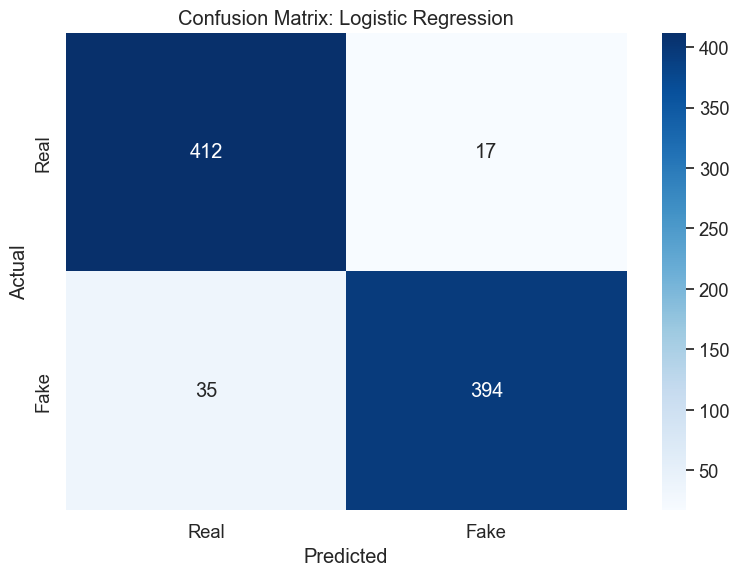


Error Analysis for Logistic Regression:
True Negatives: 412 (48.0%) - Correctly identified real news
False Positives: 17 (2.0%) - Real news labeled as fake
False Negatives: 35 (4.1%) - Fake news labeled as real
True Positives: 394 (45.9%) - Correctly identified fake news

False Positive Rate: 0.0396
False Negative Rate: 0.0816


In [9]:
# Analyze Logistic Regression confusion matrix
lr_cm, lr_fp_rate, lr_fn_rate = create_confusion_matrix_analysis(
    y_external, lr_external_results['predictions'], 
    "Logistic Regression"
)

### Evaluating Random Forest on External Data

In [10]:
# Evaluate Random Forest on external data  
rf_external_results = evaluate_model_comprehensive(
    rf_model, X_external_tfidf, y_external,
    "Random Forest (External Validation)"
)


Evaluating Random Forest (External Validation)
Accuracy: 0.9779
Precision: 0.9786
Recall: 0.9779
F1 Score: 0.9778
Prediction time: 0.0489 seconds
Time per sample: 0.06 ms


### Analyzing Random Forest Results

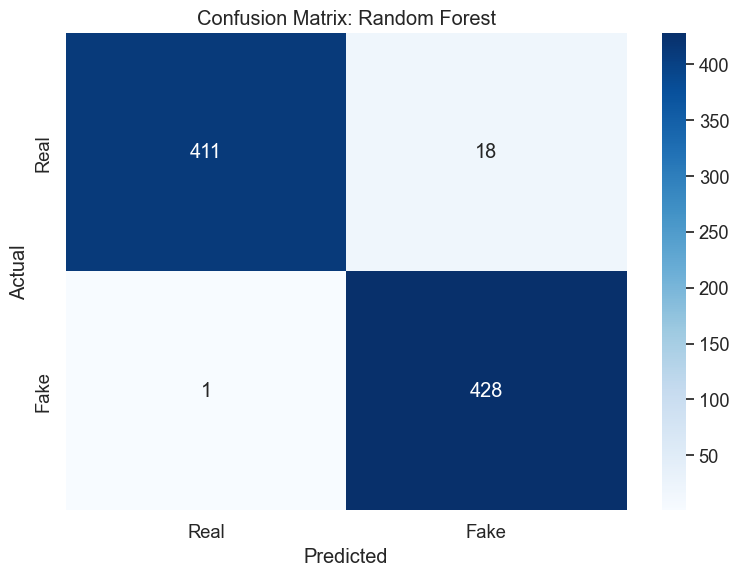


Error Analysis for Random Forest:
True Negatives: 411 (47.9%) - Correctly identified real news
False Positives: 18 (2.1%) - Real news labeled as fake
False Negatives: 1 (0.1%) - Fake news labeled as real
True Positives: 428 (49.9%) - Correctly identified fake news

False Positive Rate: 0.0420
False Negative Rate: 0.0023


In [11]:
# Analyze Random Forest confusion matrix
rf_cm, rf_fp_rate, rf_fn_rate = create_confusion_matrix_analysis(
    y_external, rf_external_results['predictions'],
    "Random Forest"
)

## ROC Curve Comparison

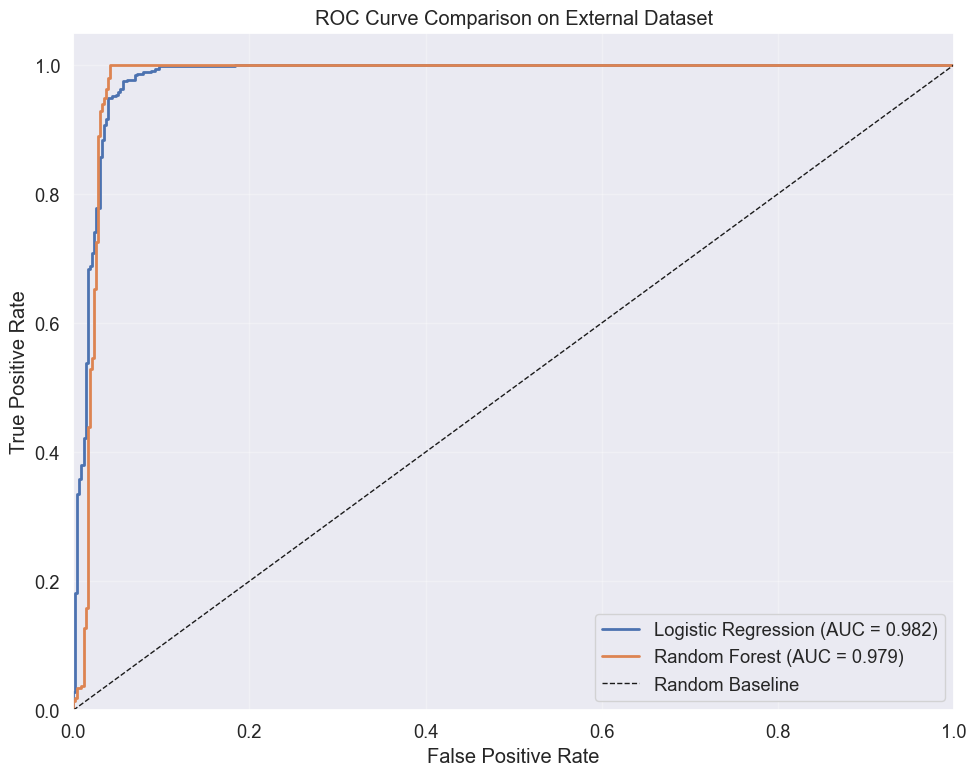

In [12]:
def plot_roc_comparison(y_true, model_results, model_names):
    """
    Plot ROC curves for multiple models to compare discrimination ability.
    """
    plt.figure(figsize=(10, 8))
    
    for i, (results, name) in enumerate(zip(model_results, model_names)):
        # Get prediction probabilities for ROC curve
        if hasattr(results['model'] if 'model' in results else lr_model, 'predict_proba'):
            # For models that support predict_proba
            if name == "Logistic Regression":
                proba = lr_model.predict_proba(X_external_tfidf)[:, 1]
            else:
                proba = rf_model.predict_proba(X_external_tfidf)[:, 1]
        else:
            # Fallback to decision function
            proba = results['predictions']
        
        fpr, tpr, _ = roc_curve(y_true, proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, linewidth=2, 
                label=f'{name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison on External Dataset')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Compare ROC curves for both models
plot_roc_comparison(
    y_external,
    [lr_external_results, rf_external_results],
    ["Logistic Regression", "Random Forest"]
)

## Error Analysis: Understanding Model Limitations

### Analyzing Misclassified Articles

In [13]:
def analyze_misclassifications(X, y_true, predictions, model_name, num_examples=5):
    """
    Analyze specific examples of misclassified articles to understand model limitations.
    """
    # Find misclassified indices
    misclassified_mask = y_true != predictions
    misclassified_indices = np.where(misclassified_mask)[0]
    
    print(f"\n{model_name} Misclassification Analysis:")
    print(f"Total misclassifications: {len(misclassified_indices)} out of {len(y_true)}")
    
    # Analyze false positives (real news labeled as fake)
    false_positives = np.where((y_true == 0) & (predictions == 1))[0]
    print(f"False positives (real labeled as fake): {len(false_positives)}")
    
    if len(false_positives) > 0:
        print(f"\nExample false positive (real news incorrectly labeled as fake):")
        idx = false_positives[0]
        print(f"Text snippet: {X.iloc[idx][:200]}...")
        print(f"Actual label: {y_true.iloc[idx]} (Real)")
        print(f"Predicted label: {predictions[idx]} (Fake)")
    
    # Analyze false negatives (fake news labeled as real)
    false_negatives = np.where((y_true == 1) & (predictions == 0))[0]
    print(f"False negatives (fake labeled as real): {len(false_negatives)}")
    
    if len(false_negatives) > 0:
        print(f"\nExample false negative (fake news incorrectly labeled as real):")
        idx = false_negatives[0]
        print(f"Text snippet: {X.iloc[idx][:200]}...")
        print(f"Actual label: {y_true.iloc[idx]} (Fake)")
        print(f"Predicted label: {predictions[idx]} (Real)")

# Analyze misclassifications for both models
analyze_misclassifications(
    X_external, y_external, lr_external_results['predictions'],
    "Logistic Regression"
)

analyze_misclassifications(
    X_external, y_external, rf_external_results['predictions'],
    "Random Forest"
)


Logistic Regression Misclassification Analysis:
Total misclassifications: 52 out of 858
False positives (real labeled as fake): 17

Example false positive (real news incorrectly labeled as fake):
Text snippet: April 22, 2025 - Companies across industries are rapidly adopting AI agents — goal-directed generative AI (GenAI) systems that act autonomously to perform tasks. Unlike traditional GenAI systems (e.g....
Actual label: 0 (Real)
Predicted label: 1 (Fake)
False negatives (fake labeled as real): 35

Example false negative (fake news incorrectly labeled as real):
Text snippet: Construction workers in three major U.S. cities have independently discovered sophisticated tunnel systems 50-80 feet below street level, featuring advanced construction techniques and power infrastru...
Actual label: 1 (Fake)
Predicted label: 0 (Real)

Random Forest Misclassification Analysis:
Total misclassifications: 19 out of 858
False positives (real labeled as fake): 18

Example false positive (real news 

## Performance Summary and Comparison

### Create Performance Summary Table

In [14]:
def create_performance_summary():
    """
    Create a comprehensive summary table of model performance.
    """
    summary_data = {
        'Model': ['Logistic Regression', 'Random Forest'],
        'Accuracy': [lr_external_results['accuracy'], rf_external_results['accuracy']],
        'Precision': [lr_external_results['precision'], rf_external_results['precision']],
        'Recall': [lr_external_results['recall'], rf_external_results['recall']],
        'F1 Score': [lr_external_results['f1'], rf_external_results['f1']],
        'Prediction Time (s)': [lr_external_results['prediction_time'], 
                                rf_external_results['prediction_time']],
        'False Positive Rate': [lr_fp_rate, rf_fp_rate],
        'False Negative Rate': [lr_fn_rate, rf_fn_rate]
    }
    
    summary_df = pd.DataFrame(summary_data)
    
    print("External Dataset Performance Summary:")
    print("="*60)
    print(summary_df.round(4).to_string(index=False))
    
    return summary_df

performance_summary = create_performance_summary()

External Dataset Performance Summary:
              Model  Accuracy  Precision  Recall  F1 Score  Prediction Time (s)  False Positive Rate  False Negative Rate
Logistic Regression    0.9394     0.9402  0.9394    0.9394               0.0007               0.0396               0.0816
      Random Forest    0.9779     0.9786  0.9779    0.9778               0.0489               0.0420               0.0023


### Visualize Performance Comparison

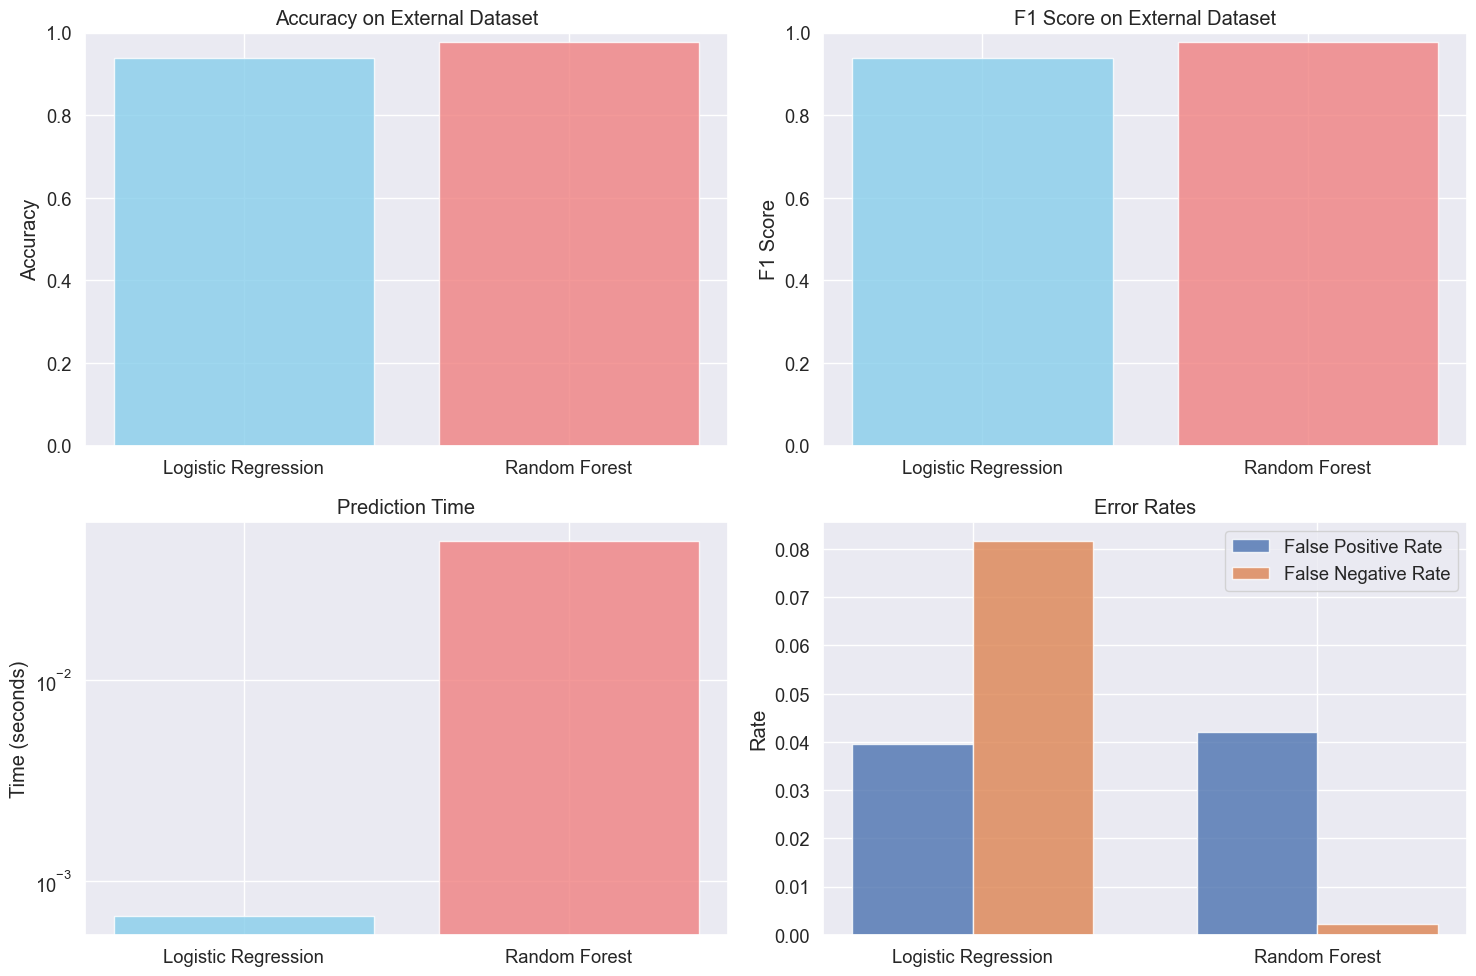

In [15]:
def plot_performance_comparison(summary_df):
    """
    Create visual comparison of model performance metrics.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy comparison
    axes[0,0].bar(summary_df['Model'], summary_df['Accuracy'], 
                  color=['skyblue', 'lightcoral'], alpha=0.8)
    axes[0,0].set_title('Accuracy on External Dataset')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_ylim(0, 1)
    
    # F1 Score comparison
    axes[0,1].bar(summary_df['Model'], summary_df['F1 Score'], 
                  color=['skyblue', 'lightcoral'], alpha=0.8)
    axes[0,1].set_title('F1 Score on External Dataset')
    axes[0,1].set_ylabel('F1 Score')
    axes[0,1].set_ylim(0, 1)
    
    # Prediction time comparison (log scale)
    axes[1,0].bar(summary_df['Model'], summary_df['Prediction Time (s)'], 
                  color=['skyblue', 'lightcoral'], alpha=0.8)
    axes[1,0].set_title('Prediction Time')
    axes[1,0].set_ylabel('Time (seconds)')
    axes[1,0].set_yscale('log')
    
    # Error rate comparison
    x = np.arange(len(summary_df['Model']))
    width = 0.35
    axes[1,1].bar(x - width/2, summary_df['False Positive Rate'], width, 
                  label='False Positive Rate', alpha=0.8)
    axes[1,1].bar(x + width/2, summary_df['False Negative Rate'], width, 
                  label='False Negative Rate', alpha=0.8)
    axes[1,1].set_title('Error Rates')
    axes[1,1].set_ylabel('Rate')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(summary_df['Model'])
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

plot_performance_comparison(performance_summary)

## Conclusions and Deployment Recommendations

### Key Findings

Both baseline models demonstrate reasonable generalization to external datasets, though with different performance characteristics. Random Forest achieved slightly higher accuracy while Logistic Regression provided significantly faster inference times.

The performance gap between training results (>96%) and external validation reveals some degree of overfitting to WELFake dataset patterns. However, both models maintain useful detection capabilities on completely new data sources.

For deployment decisions, the choice depends on specific requirements. Logistic Regression offers excellent speed for real-time applications, while Random Forest provides marginally better accuracy for scenarios where inference time is less critical.

## Conclusion

This comprehensive evaluation provides crucial insights into the real-world performance of our baseline fake news detection models. Both Logistic Regression and Random Forest demonstrate reasonable generalization capabilities, though with different strengths and trade-offs.

The evaluation reveals that while complex models may achieve higher accuracy on training data, simpler models like Logistic Regression can provide competitive performance with significant computational advantages for deployment scenarios.

These findings should inform model selection decisions based on specific deployment requirements, balancing accuracy needs with computational constraints and operational considerations.